<a href="https://colab.research.google.com/github/Pperezhogin/pyqg_generative/blob/master/Google-Colab/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Needed only on Google Colab
try:
    import google.colab
    !pip install aiohttp requests zarr pyfftw gcm_filters pyqg
    !pip install git+https://github.com/m2lines/pyqg_generative.git
    print('\n------------- Packages on Google Colab are installed ------------')
except:
    print('\n------------- Not running on Google Colab --------------')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 68.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 94.7 MB/s eta 0:00:00
  Created wheel for pyqg: filename=pyqg-0.7.2-cp38-cp38-linux_x86_64.whl size=933181 sha256=7836ac343b730843a26737d908fe1a3ed7621d40bfe19fdcd98c85cd00a0e7dd
  Stored in directory: /root/.cache/pip/wheels/a2/e3/ed/02db1e393bf087cc9729ef23e34080ea15cdc6322dbc0aace7
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=f374087d630657180fe1435f38e24104ca2563b5f487571ec28e0

In [2]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
def open_zarr(folder):
    for url, label in zip(['https://g-402b19.00888.8540.data.globus.org', 'https://g-771f59.00888.8540.data.globus.org'], ['archive', 'scratch']):
      try:
        mapper = fsspec.get_mapper(f'{url}/{folder}.zarr')
        return xr.open_zarr(mapper, consolidated=True)
      except:
        print(f'{folder} on {label} failed')

In [4]:
if True:
    # Try training on subset of data
    train_size = 5
    test_size = 2
    time_size = -5
else:
    # Full dataset
    train_size = 250
    test_size = 25
    time_size = None

In [13]:
ds = open_zarr('eddy/48/sharp')

In [ ]:
train = ds.isel(run=slice(0,train_size), time=slice(time_size,None)).load()
test = ds.isel(run=slice(train_size,train_size+test_size), time=slice(time_size,None)).load()

# Training of the GAN model and saving to 'GAN' folder

In [15]:
from pyqg_generative.models.cgan_regression import CGANRegression
gan = CGANRegression(nx=48, folder='GAN')

In [16]:
gan.fit(train, test)

Training starts on device Tesla T4, number of samples 25
[1/200] [7.15/1422.57] D_loss: -0.00 G_loss: -0.06 L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
[2/200] [0.51/757.80] D_loss: -0.06 G_loss: -0.17 L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
[3/200] [0.51/536.01] D_loss: -0.13 G_loss: -0.32 L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
[4/200] [0.51/425.14] D_loss: -0.21 G_loss: -0.55 L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
[5/200] [0.51/358.13] D_loss: -0.33 G_loss: -0.93 L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
[6/200] [0.51/313.29] D_loss: -0.50 G_loss: -1.63 L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
[7/200] [0.52/281.49] D_loss: -0.75 G_loss: -2.86 L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
[8/200] [0.51/257.17] D_loss: -1.07 G_loss: -5.06 L2_mean: [1.002,1.002] L2_total: [1.000,1.000] L2_res: [1.0

#Read the GAN model from the disk

In [17]:
import json
def read_model(folder):
  with open(f'{folder}/model_args.json') as file:
    model_args = json.load(file)
    return eval(model_args.pop('model'))(**model_args)

In [18]:
gan = read_model('GAN')

#Plotting training loss and metrics

In [19]:
stats = xr.open_dataset('GAN/stats.nc')

In [20]:
stats

<xarray.Dataset>
Dimensions:           (epoch: 200, lev: 2)
Coordinates:
  * epoch             (epoch) int64 1 2 3 4 5 6 7 ... 195 196 197 198 199 200
  * lev               (lev) int64 1 2
Data variables: (12/13)
    D_grad            (epoch) float64 ...
    D_drift           (epoch) float64 ...
    G_loss            (epoch) float64 ...
    D_loss            (epoch) float64 ...
    L2_mean           (epoch) float64 ...
    L2_total          (epoch) float64 ...
    ...                ...
    var_ratio         (epoch, lev) float32 ...
    L2_mean_test      (epoch) float64 ...
    L2_total_test     (epoch) float64 ...
    L2_residual_test  (epoch) float64 ...
    loss              (epoch) float64 ...
    Epoch_opt         float64 ...

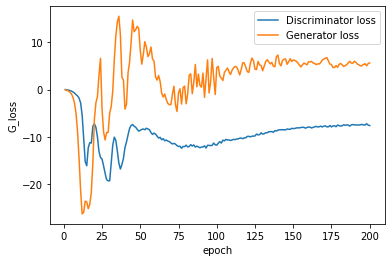

In [21]:
stats.D_loss.plot(label='Discriminator loss')
stats.G_loss.plot(label='Generator loss')
plt.legend()

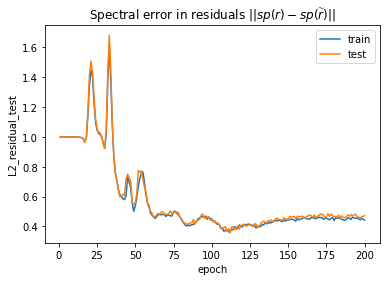

In [22]:
stats.L2_residual.plot(label='train')
stats.L2_residual_test.plot(label='test')
plt.title('Spectral error in residuals $||sp(r)-sp(\widetilde{r})||$')
plt.legend()

#Train VAE model

In [23]:
from pyqg_generative.models.cvae_regression import CVAERegression
vae = CVAERegression(folder='VAE')

In [24]:
vae.fit(train, test)

Training starts on device Tesla T4, number of samples 25
[1/200] [0.54/108.20] MSE/KL: [1.374, 1262.154] Var: [1.245,1.581] L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000] Var_ratio: [0.000, 0.000]
[2/200] [0.50/103.01] MSE/KL: [1.326, 1079.428] Var: [1.205,1.501] L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000] Var_ratio: [0.000, 0.000]
[3/200] [0.49/100.35] MSE/KL: [1.292, 988.904] Var: [1.188,1.461] L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000] Var_ratio: [0.000, 0.000]
[4/200] [0.50/99.62] MSE/KL: [1.263, 914.875] Var: [1.176,1.428] L2_mean: [1.000,1.000] L2_total: [1.000,1.000] L2_res: [1.000,1.000] Var_ratio: [0.000, 0.000]
[5/200] [0.50/98.92] MSE/KL: [1.232, 851.642] Var: [1.165,1.400] L2_mean: [1.000,1.000] L2_total: [1.000,1.000] L2_res: [1.000,1.000] Var_ratio: [0.000, 0.000]
[6/200] [0.52/98.77] MSE/KL: [1.212, 794.094] Var: [1.156,1.375] L2_mean: [1.000,1.000] L2_total: [1.000,1.000] L2_res: [1.000,1.000] Var_

In [25]:
del vae
vae = read_model('VAE')

#Train GZ model

In [26]:
from pyqg_generative.models.mean_var_model import MeanVarModel
gz = MeanVarModel(folder='GZ')

In [27]:
gz.fit(train, test)

Training starts on device Tesla T4, number of samples 25
[1/50] [0.06/2.70] Loss: [1.346, 0.953]
[2/50] [0.06/2.65] Loss: [1.240, 0.952]
[3/50] [0.06/2.60] Loss: [1.137, 0.952]
[4/50] [0.06/2.54] Loss: [1.072, 0.951]
[5/50] [0.06/2.49] Loss: [1.030, 0.951]
[6/50] [0.06/2.44] Loss: [0.999, 0.950]
[7/50] [0.06/2.39] Loss: [0.974, 0.950]
[8/50] [0.06/2.33] Loss: [0.952, 0.949]
[9/50] [0.06/2.28] Loss: [0.932, 0.948]
[10/50] [0.06/2.22] Loss: [0.911, 0.947]
[11/50] [0.06/2.16] Loss: [0.890, 0.946]
[12/50] [0.06/2.11] Loss: [0.868, 0.944]
[13/50] [0.06/2.06] Loss: [0.845, 0.942]
[14/50] [0.06/2.00] Loss: [0.822, 0.939]
[15/50] [0.06/1.95] Loss: [0.798, 0.935]
[16/50] [0.06/1.89] Loss: [0.774, 0.930]
[17/50] [0.06/1.84] Loss: [0.750, 0.924]
[18/50] [0.06/1.79] Loss: [0.727, 0.917]
[19/50] [0.06/1.73] Loss: [0.704, 0.909]
[20/50] [0.06/1.68] Loss: [0.681, 0.900]
[21/50] [0.06/1.62] Loss: [0.658, 0.890]
[22/50] [0.06/1.56] Loss: [0.637, 0.878]
[23/50] [0.06/1.51] Loss: [0.617, 0.864]
[24/50] [

In [28]:
del gz
gz = read_model('GZ')